# Image Segmentation

- Image segmentation is a task in the field of computer vision, where the goal is to partition an image into distinct regions or segments that correspond to different objects or areas of interest

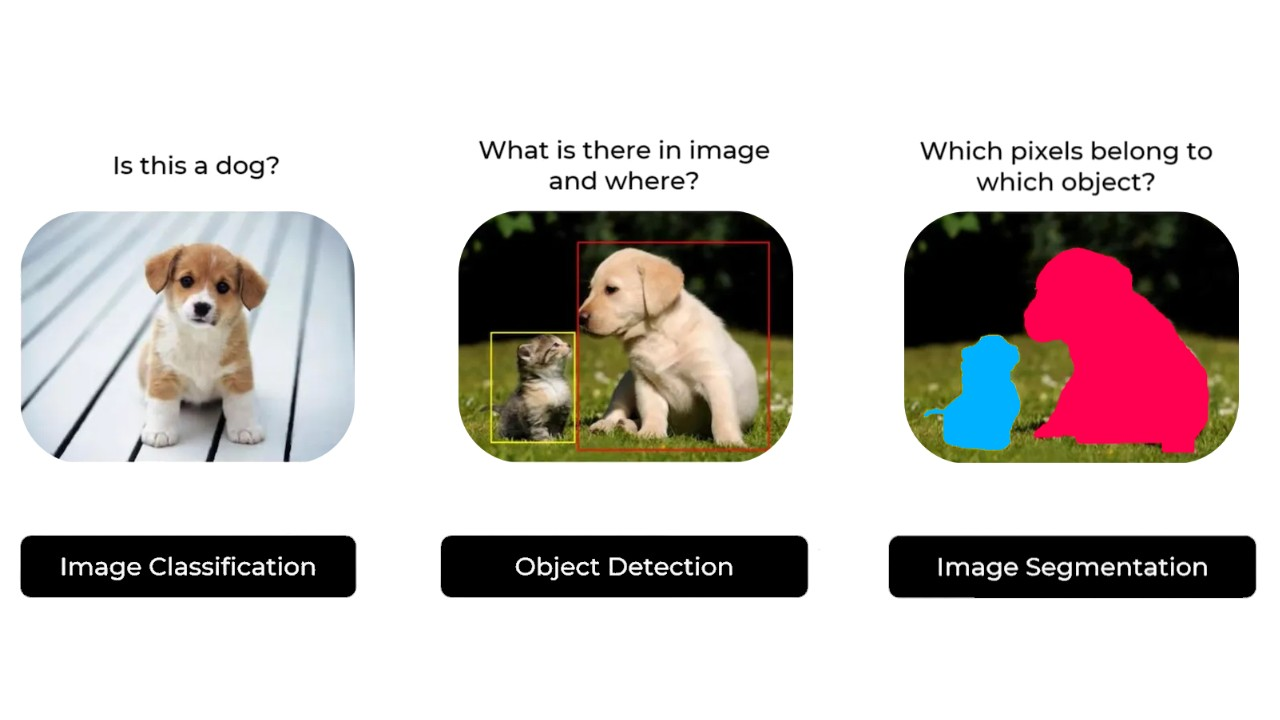

# UNET

# Introduction

- https://arxiv.org/pdf/1505.04597

- The UNet model, as per the original 2015 paper by Ronneberger et al., is a fully convolutional neural network primarily designed for biomedical image segmentation.

-  It follows an encoder-decoder structure with skip connections to capture fine-grained spatial details, which is especially useful in segmentation tasks. Let’s walk through the architecture and the PyTorch implementation.

## UNet Architecture
- **Encoder:** Consists of a series of convolutional and max-pooling layers to downsample the image, capturing high-level context and features. Each step in this path:

 - Applies two 3x3 convolutions followed by ReLU activations.
Reduces spatial dimensions by half using max pooling (2x2).
Bottleneck: At the base, it has two convolutional layers that act as a bridge between the encoder and decoder, capturing features at the lowest resolution.

- **Decoder:** Consists of upsampling operations to reconstruct the image resolution. It features:

 - Transpose convolutions (up-convolutions) to increase spatial resolution.
Skip connections from the encoder layers to retain fine-grained features, which are concatenated with the upsampled output.
Final Layer: A 1x1 convolution reduces the channel dimension to the number of segmentation classes.

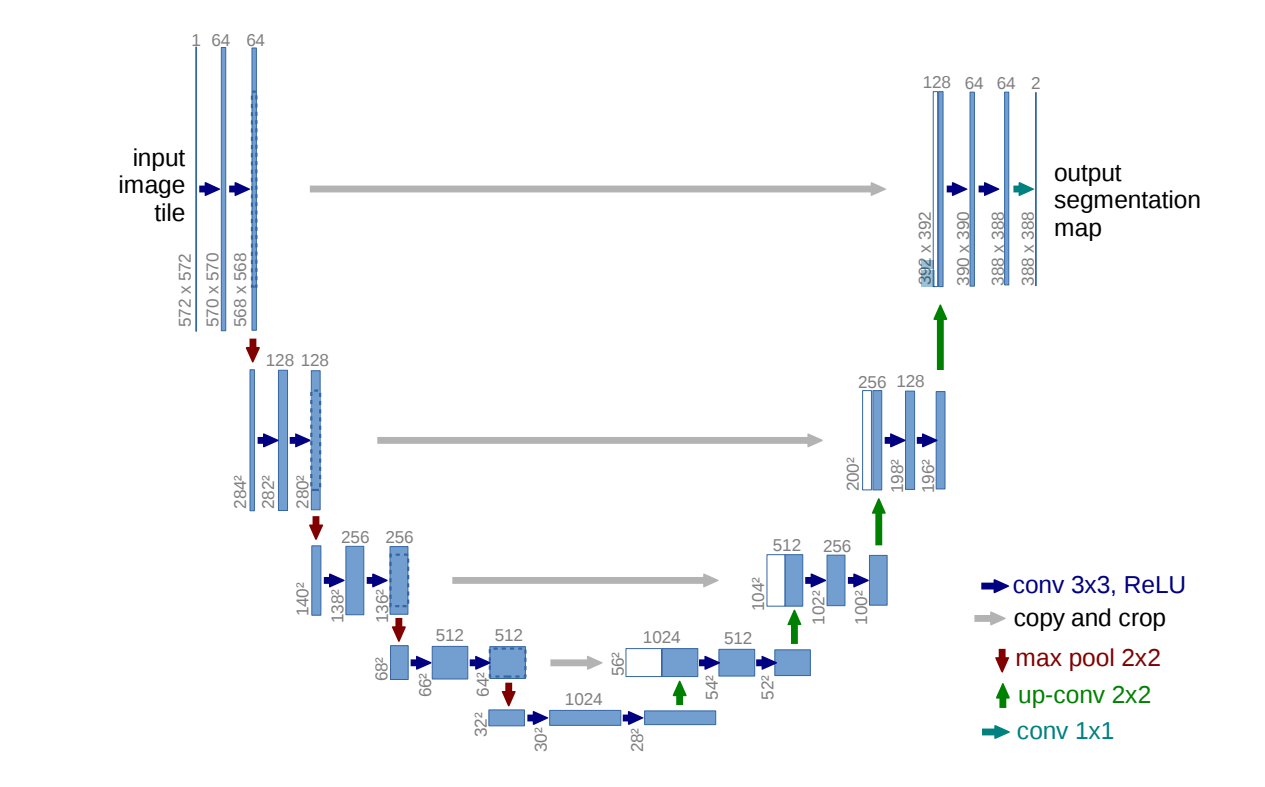

## Training with Different Input and Output Shapes
- No Padding in Convolutions: The UNet model uses unpadded convolutions, reducing the output dimensions to focus on a core, valid region of the input image.

- Cropped Ground Truth Labels: The ground truth labels are centrally cropped to match the output size (e.g.,
388
×
388
388×388), enabling pixel-level comparison in the core region only.

- Loss Computation: Loss is calculated only on the central region where prediction and ground truth align, improving segmentation accuracy in this area.

- Data Augmentation: Extensive augmentation compensates for reduced effective area, improving model generalization across diverse shapes and sizes in biomedical images.

## Advantage

- Precise Localization with Skip Connections:

 - UNet’s skip connections directly link encoder layers to corresponding decoder layers, allowing the model to combine high-level context with detailed spatial information. This is crucial in biomedical imaging, where identifying small structures—such as cells, tissues, or lesions—requires high spatial accuracy and context preservation.

- No Need for Large Datasets:
 - Biomedical data is often limited, making data efficiency essential. UNet was designed with smaller datasets in mind and has proven effective even with relatively few labeled samples. Its architecture was originally tailored to work with limited annotated medical images by utilizing data augmentation and other techniques.

# Implementation

In [2]:
import torch
import torch.nn as nn

In [24]:
class Unet(nn.Module):
    def __init__(self,in_channels=1,out_channels=2):
        super(Unet,self).__init__()

        # Encoder
        self.enc1 = self.conv_block(in_channels,64)
        self.enc2 = self.conv_block(64,128)
        self.enc3 = self.conv_block(128,256)
        self.enc4 = self.conv_block(256,512)

        # bottleneck features
        self.bottleneck = self.conv_block(512,1024)

        # decoder

        self.upconv4 = nn.ConvTranspose2d(1024,512,kernel_size=2,stride=2)
        self.dec4 = self.conv_block(1024,512)

        self.upconv3 = nn.ConvTranspose2d(512,256,kernel_size=2,stride=2)
        self.dec3 = self.conv_block(512,256)

        self.upconv2 = nn.ConvTranspose2d(256,128,kernel_size=2,stride=2)
        self.dec2 = self.conv_block(256,128)

        self.upconv1 = nn.ConvTranspose2d(128,64,kernel_size=2,stride=2)
        self.dec1 = self.conv_block(128,64)

        self.final_layer = nn.Conv2d(64,out_channels,kernel_size=1)


    def conv_block(self,in_channels,out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels,out_channels,kernel_size=3),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels,out_channels,kernel_size=3),
            nn.ReLU(inplace=True)
        )

    def crop(self,enc_op,dec_op):

        enc_op_size = enc_op.size()[2:] # height, width
        dec_op_size = dec_op.size()[2:] # height, width

        delta_h = enc_op_size[0] - dec_op_size[0]
        delta_w = enc_op_size[1] - dec_op_size[1]

        return enc_op[:,:,delta_h//2:enc_op_size[0]-delta_h//2, delta_w//2:enc_op_size[1]-delta_w//2]


    def forward(self,x):

        # Encoder
        enc1 = self.enc1(x)
        enc2 = self.enc2(nn.MaxPool2d(kernel_size=2)(enc1))
        enc3 = self.enc3(nn.MaxPool2d(kernel_size=2)(enc2))
        enc4 = self.enc4(nn.MaxPool2d(kernel_size=2)(enc3))

        # BottleNeck
        bottleneck = self.bottleneck(nn.MaxPool2d(kernel_size=2)(enc4))

        # Decoder

        dec4 = self.upconv4(bottleneck)
        dec4 = self.dec4(
                        torch.cat((dec4, self.crop(enc4,dec4)),dim=1)
                        )
        dec3 = self.upconv3(dec4)
        dec3 = self.dec3(
                        torch.cat((dec3, self.crop(enc3,dec3)),dim=1)
                        )

        dec2 = self.upconv2(dec3)
        dec2 = self.dec2(
                        torch.cat((dec2, self.crop(enc2,dec2)),dim=1)
                        )

        dec1 = self.upconv1(dec2)
        dec1 = self.dec1(
                        torch.cat((dec1, self.crop(enc1,dec1)),dim=1)
                        )

        return self.final_layer(dec1)

In [25]:
model = Unet()

In [26]:
!pip install torchview

In [27]:
from torchview import draw_graph

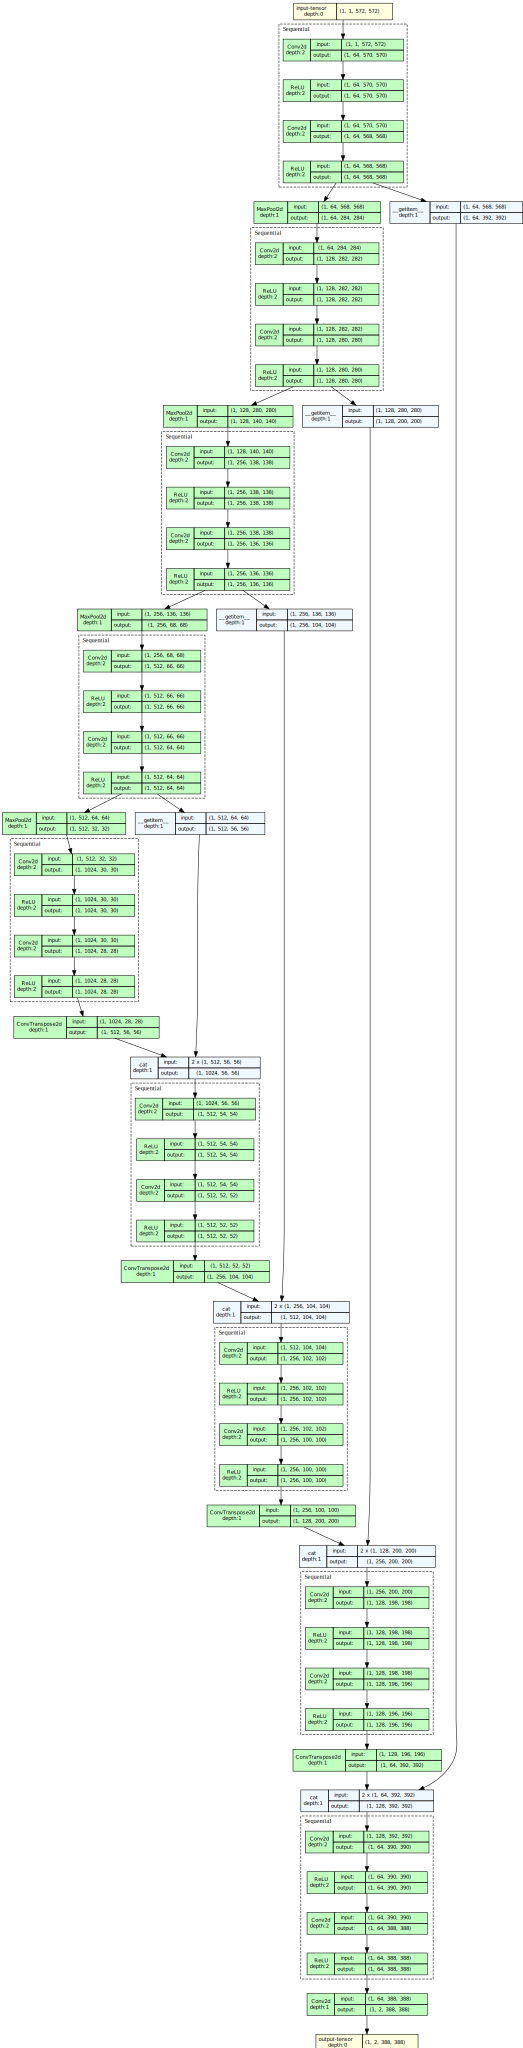

In [29]:
draw_graph(model,input_size=(1,1,572,572),expand_nested=True).visual_graph